# BioMedical Data Mining
#### Orhan Aytekin

The ultimate goal of biomedical data mining in healthcare applications is to seek for hidden trends, patterns from the voluminous data, and it is broadly utilized to predict various diseases in the medical industry.
    I have chosen the path of seeking for hidden trends and I have used Latent Dirichlet Allocation (LDA) to achieve that 
    and also used it for topic modelling.

   I've used the Gensims’s topic coherence pipeline coherencemodel
   to find the optimal number of topics based on the cv metric. 
   And I've used the Mann- Kendall test to understand the trends of the topics.
   
   There is also an entity recognition part, for that I've used some Named Entity Recognition (NER) models from scispacy and spacy  since that I found out these libraries already has NER models for specific entity recognition tasks.









## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Unsupervised machine learning for discovering themes and topics from 
unstructured biomedical texts.

How to analyze and visualize the evolving research trends in unstructured text
data over time?  

Text-mining methods for discovering relationship between biological entities.

## Data Understanding<a class="anchor" id="data_understanding"></a>

I will gather the data from https://pubmed.ncbi.nlm.nih.gov/.

**PubMed®** comprises more than 35 million citations for biomedical literature from MEDLINE, life science journals, and online books. Citations may include links to full text content from PubMed Central and publisher web sites.

To access and download the data programatically from PubMed I will use the API of National Center for Biotechnology Information (NCBI) it is called Entrez Databases and Retrieval System.

**Entrez** is a molecular biology database system that provides integrated access to nucleotide and protein sequence data, gene-centered and genomic mapping information, 3D structure data, PubMed MEDLINE, and more. The system is produced by the National Center for Biotechnology Information (NCBI) and is available via the Internet.

Records consists of articles: <br>
<code>    </code>    Titles,<br>
<code>    </code>    Abstracts,<br>
<code>    </code>    Texts,<br>
<code>    </code>    Timestamps and such attributes for each article.

## Data Preparation<a class="anchor" id="data_preparation"></a>

**Imports**<br>
<font color="grey">My goal here is to show the used modules and for the sake of readability, I did not remove the imports from the codes.</font>

In [177]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Bio import Entrez, Medline
from io import StringIO
import matplotlib.cm as cm
import sklearn
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.test.utils import datapath
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import scispacy
import spacy
from pytagcloud import create_tag_image, make_tags
from matplotlib.patches import Patch
import pymannkendall as mk
import random 
from spacy import displacy
from collections import Counter
from gensim.matutils import corpus2dense
from sklearn.metrics.pairwise import cosine_similarity
import pickle

Here are the global variables, that will be used for getting the data.

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Bio import Entrez, Medline
from io import StringIO

# Needed for Entrez: If there is too many requests from a user 
# You will be warned about getting restricted.
email = "contactorhanaytekin@gmail.com"

# Search queries to get specific articles
query_list = [
            "The role of microRNAs in cancer development and progression",
            "The use of CRISPR/Cas9 for gene editing in biomedical research",
            "Base excision repair (BER)",
            "Nucleotide excision repair (NER)",
            "Non-homologous end joining (NHEJ)",
            "Mismatch Repair (MMR)",
            "Homologous recombination repair (HRR)",
            "The development of nanotechnology-based therapies for cancer",
            "The use of machine learning algorithms in medical diagnosis and treatment planning",
            ]

# Date of Publication "DP", Abstract for "AB", and "TI" for title
date = "DP"
abstract = "AB"
title = "TI"

date_list = []
abstract_list = []
title_list = []

cols = [
    "ID",
    "Date",
    "Title",
    "Abstract",
]

In [12]:
def search_data(email, query):
    """
    Searches pubmed for a given query and returns a id_list of articles
    Note: retmax variable controls the count of returned articles
    """
    Entrez.email = email

    handle = Entrez.esearch(
        db="pubmed", term=query, retmin=0, retmax=10_000)  # warning: handle retmax it SHOULD NOT BE ZERO
    rec = Entrez.read(handle)
    id_list = rec["IdList"]  
    print(f"There are {rec['Count']} articles for the query {query}.")  
    handle.close()
    return id_list

In [13]:
def print_abstract(pmid):
    """Using Entrez's efetch function, gets the articles based on the pmid (Article ID)
    """
    handle = Entrez.efetch(db='pubmed', id=pmid,
                           rettype="Medline", retmode='text')
    rec = handle.read()
    handle.close()
    return rec

Using the StringIO and Medline.parse functions we get a records attribute that contains all the informations on articles.

Since some of the articles might collide for given search queries, we will remove duplicates.

In [14]:
id_list = []

for query in query_list:
    id_list.extend(search_data(email, query))
    
id_list = list(set(id_list)) #remove duplicates

recs = print_abstract(id_list)
recs_string = StringIO(recs)
records = Medline.parse(recs_string)
print(f"Total distinct record count: {len(id_list)}.")

There are 5031 articles for the query The role of microRNAs in cancer development and progression.
There are 1070 articles for the query The use of CRISPR/Cas9 for gene editing in biomedical research.
There are 2599 articles for the query Base excision repair (BER).
There are 2928 articles for the query Nucleotide excision repair (NER).
There are 6055 articles for the query Non-homologous end joining (NHEJ).
There are 4828 articles for the query Mismatch Repair (MMR).
There are 556 articles for the query Homologous recombination repair (HRR).
There are 339 articles for the query The development of nanotechnology-based therapies for cancer.
There are 515 articles for the query The use of machine learning algorithms in medical diagnosis and treatment planning.
Total distinct record count: 22887.


In [15]:
# Discard NULL values
for med in records:
    try:    
        date_list.append(med[date])
        title_list.append(med[title])
        abstract_list.append(med[abstract])
    except KeyError:
        continue

# j[:4] is for timestamps, I will only get the year
data = [ [i,j[:4],k,l] for (i,j,k,l) in zip(id_list, date_list, title_list, abstract_list)]

# Create a dataframe from the data
df = pd.DataFrame(data, columns = cols)
df.head(10)

,ID,Date,Title,Abstract
0,29038000,2018,Epigenetic regulation of miR-200 as the potent...,"MicroRNAs (miRNAs) are a class of small, non-c..."
1,28643253,2017,Genome Editing of Rat.,Many genetically engineered rat strains have b...
2,32925081,2021,Drugging DNA Damage Repair Pathways for Trinuc...,DNA damage repair (DDR) mechanisms have been i...
3,29618288,2018,Upregulation of MiR-212 Inhibits Migration and...,BACKGROUND: MicroRNAs are involved in hepatoce...
4,35273179,2022,Estrogen receptor inhibition mediates radiosen...,Endocrine therapy (ET) is an effective first-l...
5,27951718,2016,[Molecular Pathogenesis of Colorectal Cancer].,BACKGROUND: Colorectal cancer (CRC) remains a ...
6,32048611,2020,Circular RNA hsa_circ_0056836 functions an onc...,BACKGROUND: Circular RNA (circRNA) remains a t...
7,29738762,2018,Circular RNA hsa_circ_0023404 exerts an oncoge...,Cervical cancer (CC) is one of the most preval...
8,33200230,2021,Diagnostic and therapeutic role of microRNAs i...,Oral cancer is one of the leading types of can...
9,20724916,2010,"3,3'-Diindolylmethane negatively regulates Cdc...","3,3'-Diindolylmethane (DIM) is a potential che..."


In [ ]:
word_count_dict = {}

# For each article concatenate the title and abstract
for i in range(df.shape[0]):
    id = df.ID[i]
    title_and_abstract = f"{df.Title[i]} {df.Abstract[i]}"
    word_count = title_and_abstract.split(" ")
    word_count_dict[id] = len(word_count)

# Creating a dataframe using id, word count values for each article
df_word_count = pd.DataFrame(word_count_dict.values(), columns=["word count"])

After concatenating each article's abstract and title and creating a dataframe using id and word count values, I have plotted a bar plot using the dataframe object.

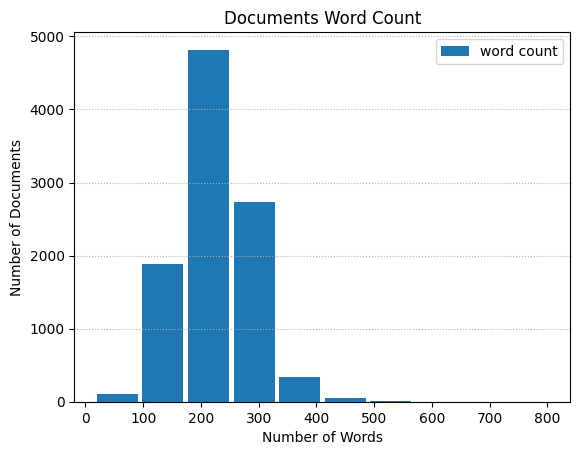

In [19]:
ax = df_word_count.plot(kind = "hist", column=["word count"],title = "Documents Word Count", rwidth=0.9)
# Add grid lines to the y-axis
ax.grid(axis="y", linestyle="dotted")

counts = df_word_count["word count"]
ax.set_xlabel("Number of Words")
ax.set_ylabel("Number of Documents")
plt.show()

This is for creating a horizontal bar plot that gives the number of publications each year.

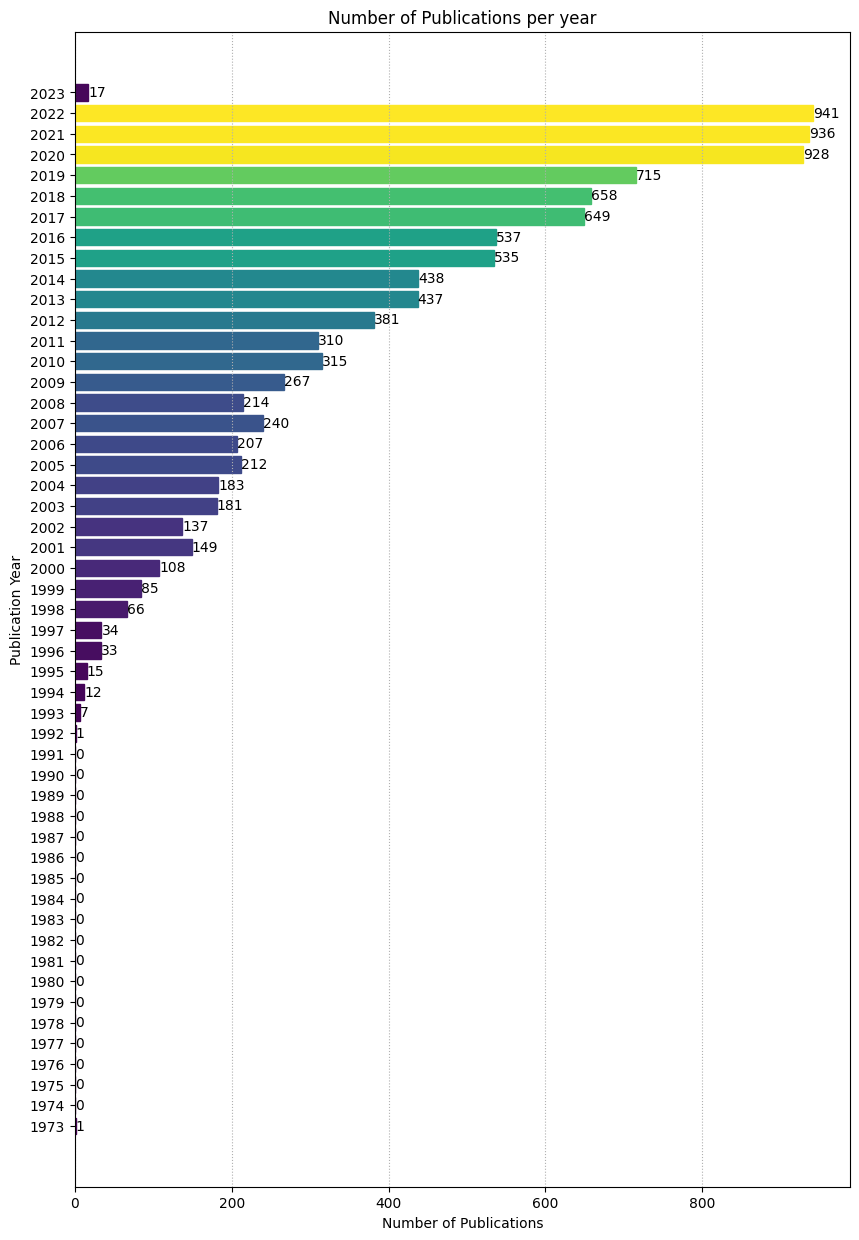

In [20]:
import matplotlib.cm as cm

# Get the number of Dates.
dict_of_d = dict(df.Date.value_counts(dropna=False))

maxval = int(max(dict_of_d.keys())) + 1
minval = int(min(dict_of_d.keys())) 

# Set the years in descending order
dict_of_doc = {
    i: 0 for i in range(maxval-1, minval-1, -1)
}

# For each year, set the value to number of articles that published that year.
for k, v in dict_of_d.items():
    dict_of_doc[int(k)] = v

values = list(dict_of_doc.values())
indexes = list(dict_of_doc.keys())

fig, ax = plt.subplots() 

# Horizontal bar plot
ax.barh(indexes, width=values, color="red")
ax.set_yticks(indexes)

bars = ax.barh(indexes, values, color="red")
ax.bar_label(bars)

# Add grid lines to the x-axis
ax.grid(axis="x", linestyle="dotted")

# Color map for creating a better visualizations.
cmap = cm.get_cmap("viridis")

# Set the colors
colors = cmap(values / max(values))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.title('Number of Publications per year')
plt.xlabel('Number of Publications')
plt.ylabel('Publication Year')
fig.set_size_inches(10,15)      
plt.show()

## Modeling<a class="anchor" id="modeling"></a>

There is 2 types of models that is being used in this project:<br>
<code>    </code> Latent Dirichlet Allocation (LDA) Models:<br>
<code>        </code> LatentDirichletAllocation from sklearn.decomposition<br>
<code>        </code> LdaModel from gensim.models <br>
<code>    </code>   Named Entity Recognition (NER) Models:<br>
<code>        </code> I have used couple of pre-trained models of scispacy library,<br>
<code>        </code> there are 3 in this project; en_ner_bionlp13cg_md and en_ner_bc5cdr_md are<br>
<code>        </code> biomedical entity recognition models and at last English language model en_core_web_sm.

Creating a **corpus** by removing stop words and stemming.<br>

In [21]:
import numpy as np
import pandas as pd
import sklearn
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.corpora import Dictionary

# Load the dataset into a Pandas DataFrame
data = df

# Documents list stores the Title, Abstract, ID and Year for each article == document
documents = []

# Preprocess the text by removing stop words and performing stemming
corpus = []
for i in range(0, len(data)):
    review = f"{df.Title[i]} {df.Abstract[i]}"
    # Only get the documents after 2000
    # Since there are far more articles after 2000, as it seems in number of publications per year plot
    if int(df.Date[i]) >= 2000:
        documents.append(f"{review} {df.ID[i]} {int(df.Date[i])}")
    review = review.lower()
    review = review.split()
    #gets the root of the word -----> likely >> like
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    #remove the words that has less than 2 characters
    review = [word for word in review if len(word) > 2]
    review = ' '.join(review)
    corpus.append(review)
    
# Turn the corpus into a list
corpus_list = [i.split() for i in corpus]

# Create a dictionary from the corpus
dictionary = Dictionary(corpus_list)

# Create a BoW representation of the corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus_list]

##### FINDING OPTIMAL NUMBER OF TOPICS
   I've used the Gensims’s topic coherence pipeline coherencemodel
   to find the optimal number of topics based on the cv metric.
    
   To do this, I've used LdaModel and CoherenceModel from gensim.models.

LdaModel class in gensim.models library takes many (optional and required) arguments these are used:<br>
<code>    </code>First it takes a Bag-of-Words (BoW) representation of corpus. (Document-term matrix.)<br>
<code>    </code>Then it takes num_topics, which is number of topics for model to divide.<br>
<code>    </code>id2word parameter is used for mpping from word IDs to words. It is used to determine <br>
<code>    </code>the vocabulary size, as well as for debugging and topic printing.<br>
<code>    </code>last parameter passes determines the number of passes through the corpus during training.<br>

In [22]:
from gensim.models import LdaModel, CoherenceModel
from gensim.test.utils import datapath

coherence_scores = []
number_of_topics = [i for i in range(7,20)]

for i in number_of_topics:
    # Create an LDA model
    lda_model = LdaModel(bow_corpus, num_topics=i, id2word=dictionary, passes=10)

    # Create a coherence model
    coherence_model = CoherenceModel(model=lda_model, texts=corpus_list, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute the Cv coherence score for the LDA model
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence score: {coherence_score:.3f}")


Coherence score: 0.569
Coherence score: 0.539
Coherence score: 0.583
Coherence score: 0.612
Coherence score: 0.610
Coherence score: 0.576
Coherence score: 0.619
Coherence score: 0.596
Coherence score: 0.622
Coherence score: 0.621
Coherence score: 0.599
Coherence score: 0.608
Coherence score: 0.569


##### Result
   After calculating coherence scores for each topic,
   line plot below shows that optimal number of topics 
   seems to be **15**. 
    
   As you can see on the plot below.

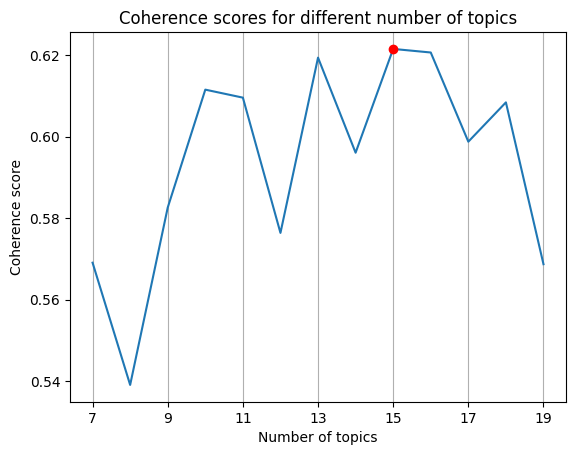

In [36]:
import matplotlib.pyplot as plt

# Make sure that the lists have the same length
assert len(coherence_scores) == len(number_of_topics)

plt.plot(number_of_topics, coherence_scores)

plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence scores for different number of topics')

max_index = coherence_scores.index(max(coherence_scores))

optimal_number_of_topics = number_of_topics[max_index]

# Add a marker at the maximum coherence score
plt.plot(number_of_topics[max_index], coherence_scores[max_index], 'ro')

# Enable the grid for the x-axis
plt.grid(True, axis='x')

# Increment x-axis by 3
plt.xticks(range(min(number_of_topics), max(number_of_topics)+1, 2))

plt.show()

LatentDirichletAllocation class in sklearn.decomposition library takes many (optional and required) arguments these are used:<br>
<code>    </code>It takes n_components, which is basically number of topics.<br>
<code>    </code>And random_state attribute that controls the random number generator. <br>
We can then use lda.fit to learn model for the data X with variational Bayes method.<br>
Or we can use lda.transform or lda.fit_transform methods to transform the data.<br>

Since we already figured out optimal number of topics as <optimal_number_of_topics> we can use it to create the optimal<br>
**LatentDirichletAllocation model from sklearn.decomposition.**

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix using CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(corpus)

# Create the optimal LDA model
lda = LatentDirichletAllocation(n_components=optimal_number_of_topics, random_state = 42)
# Fit the LDA model to the document-term matrix
lda.fit(X)

LatentDirichletAllocation(n_components=15, random_state=42)

After learning the result for optimal number of topics, I created the optimal LDA model for<br>
**LdaModel from gensim.models** too.

In [25]:
from gensim.models import LdaModel

# Create the optimal LDA model
lda_model = LdaModel(bow_corpus, num_topics=optimal_number_of_topics, id2word=dictionary, passes=10)

For entity relationship models I have used the pre-trained models from scispacy since this library<br> already has NER models for specific entity recognition tasks. Such as en_ner_bionlp13cg_md and en_ner_bc5cdr_md.<br>
And from spacy I used the English language model en_core_web_sm (Not about biomedical texts.).

In [26]:
import scispacy
import spacy

# Load the en_ner_bionlp13cg_md model
nlp_bionlp13cg = spacy.load("en_ner_bionlp13cg_md")

# Load the en_ner_bc5cdr_md model
nlp_bc5cdr = spacy.load("en_ner_bc5cdr_md")

# Load the English language model
nlp = spacy.load('en_core_web_sm')

text = ""

for i in range(len(df)):
    # WARNING
    # There is 1_000_000 length restriction as default in nlp(text) we can increase this with
    # "nlp.max_length = required length", but my computer couldn't handle such big storage needs. 
    if len(text)+len(f"{df.Abstract[i]}\t{df.Title[i]}\n")>1_000_000:
        break
    text += f"{df.Abstract[i]}\t{df.Title[i]}\n"

# Usage: Show the entities for a document
doc_bionlp13cg = nlp_bionlp13cg(text)
doc_bc5cdr = nlp_bc5cdr(text)
doc_core = nlp(text)

Since these models (LDAs and NERs) take too long to compute it might be best to save them and use later.<br>
I will do so in later parts of this file.

Which model will be used? Why? What parameters?

## Evaluation<a class="anchor" id="evaluation"></a>

### LDA Model from sklearn.decomposition Evaluation

Using the LDA model from sklearn.decomposition I extracted frequencies for each word in the topics.

In [27]:
# Prints the top words and their relative Term-Frequencies for each topic
# Define the number of top words to extract
n_top_words = 10
n_top_print = 3

top_words = []
top_3 = []
# Loop over the words in the LDA model
for word in lda.components_:
    
    # Get the indices of the top words in the topic
    top_word_indices = word.argsort()[-n_top_words:]
    # Get the indices of top 3
    top_word_indices_print = word.argsort()[-n_top_print:]

    # Get the top words and their corresponding TF-IDF values
    top_words += [(cv.get_feature_names_out()[i], word[i]) for i in top_word_indices ]
    # Get top 3 to print
    top_3 += [(cv.get_feature_names_out()[i], word[i]) for i in top_word_indices_print ]

for i in range(len(top_3)):
    print(f"word = {top_3[i][0]}, TF(Term Frequency)-IDF value = {top_3[i][1]}")
    if (i+1) % 3 == 0 and i != len(top_3)-1 :
        print("NEXT-TOPIC")

word = expans, TF(Term Frequency)-IDF value = 217.35958169601946
word = cell, TF(Term Frequency)-IDF value = 304.1889725565113
word = repeat, TF(Term Frequency)-IDF value = 424.1320513990723
NEXT-TOPIC
word = polymorph, TF(Term Frequency)-IDF value = 1152.7826721971762
word = cancer, TF(Term Frequency)-IDF value = 1187.9846553036255
word = risk, TF(Term Frequency)-IDF value = 1311.822002337407
NEXT-TOPIC
word = hepatocellular, TF(Term Frequency)-IDF value = 339.18008173656654
word = as1, TF(Term Frequency)-IDF value = 854.837195245439
word = hcc, TF(Term Frequency)-IDF value = 1541.5365058347973
NEXT-TOPIC
word = express, TF(Term Frequency)-IDF value = 4461.347288097161
word = cell, TF(Term Frequency)-IDF value = 6081.7528555952385
word = mir, TF(Term Frequency)-IDF value = 11076.95770827322
NEXT-TOPIC
word = repair, TF(Term Frequency)-IDF value = 2302.510298068579
word = ber, TF(Term Frequency)-IDF value = 2443.2143325913066
word = dna, TF(Term Frequency)-IDF value = 3506.911915419605

Using frequencies of words, I've made a word cloud using pytagcloud. This word cloud is for the whole data.

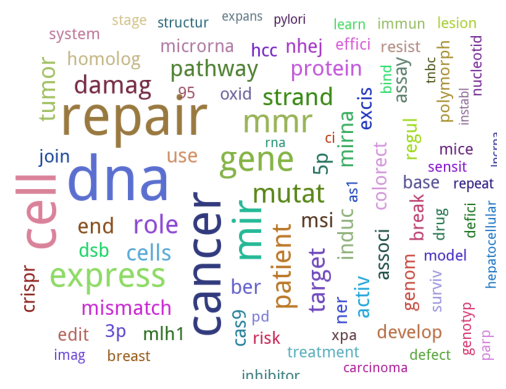

In [28]:
from pytagcloud import create_tag_image, make_tags

top_words_all = {}

# Combine the words with same name, but in different topics
for word, frequency in top_words:
    if word not in top_words_all:
        top_words_all[word] = int(frequency)
    else:
        top_words_all[word] = top_words_all[word] + int(frequency) 
    
top_words_all_list = [(word, freq) for word, freq in top_words_all.items()]

# Create a list of tags using the word frequencies
tags = make_tags(top_words_all_list, maxsize=100, minsize=20)

# Generate the word cloud image
image = create_tag_image(tags,"wordcloud.png", size=(900, 600), rectangular=True)

# Show the word cloud
image = plt.imread('wordcloud.png')
plt.imshow(image)
plt.axis("off")
plt.show()

Here are the word clouds for each of the topics.

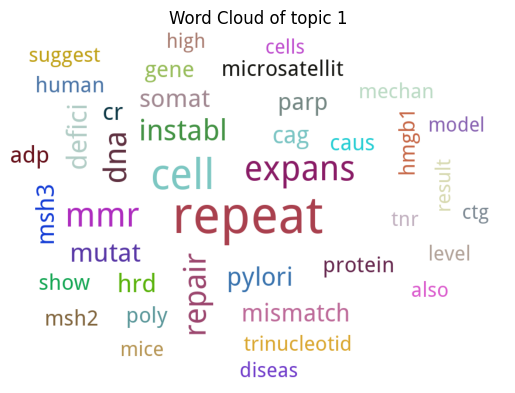

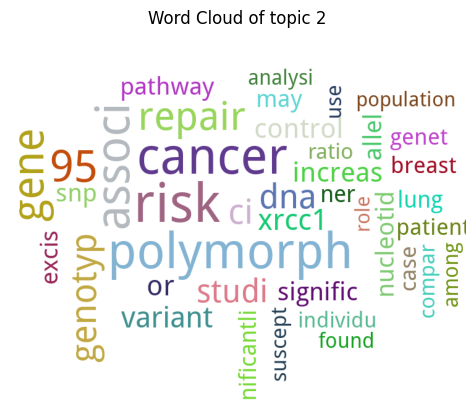

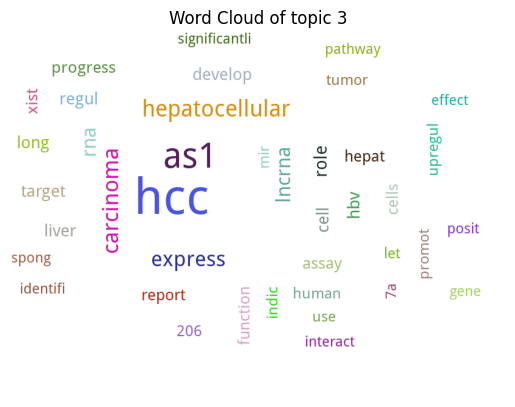

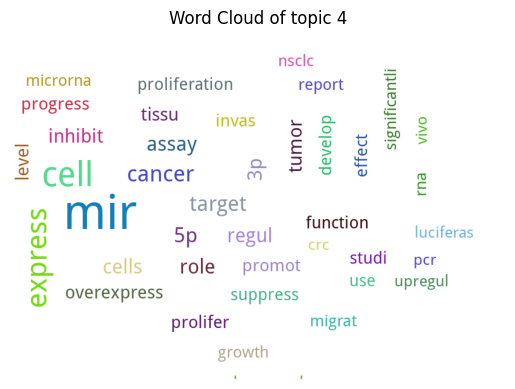

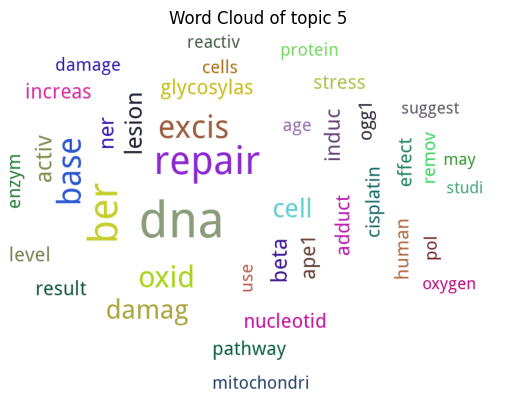

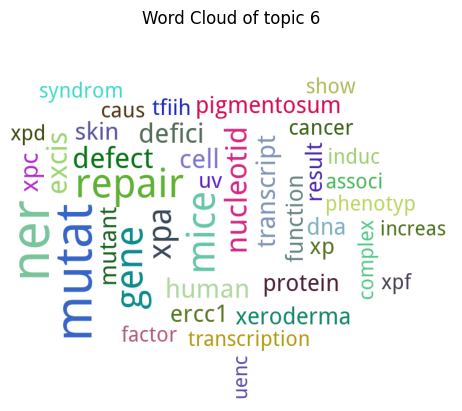

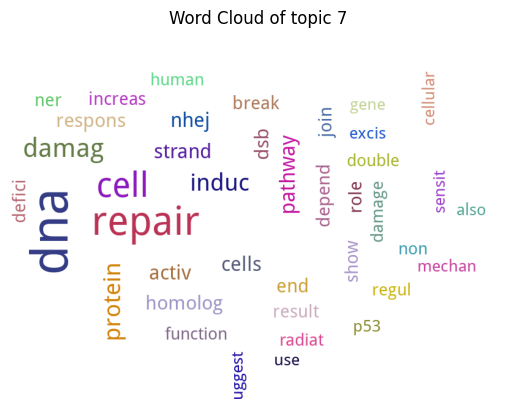

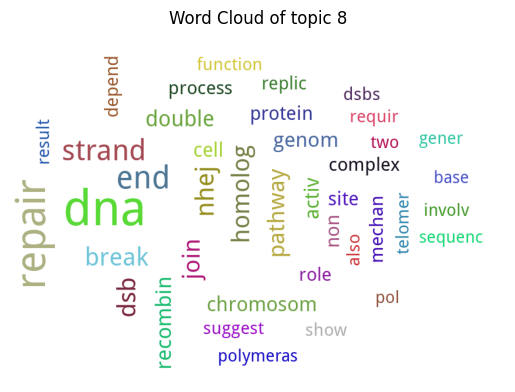

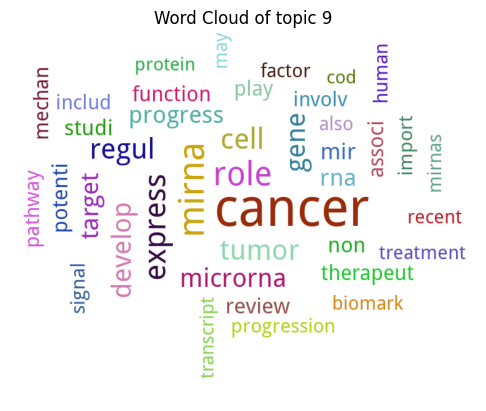

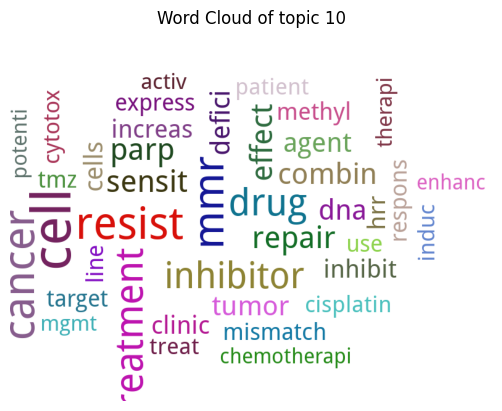

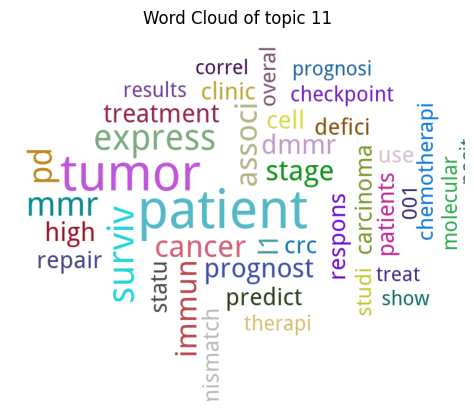

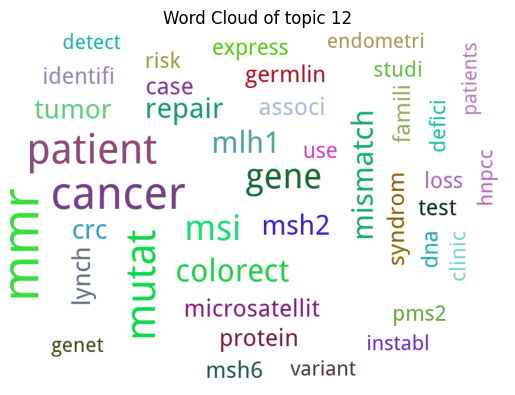

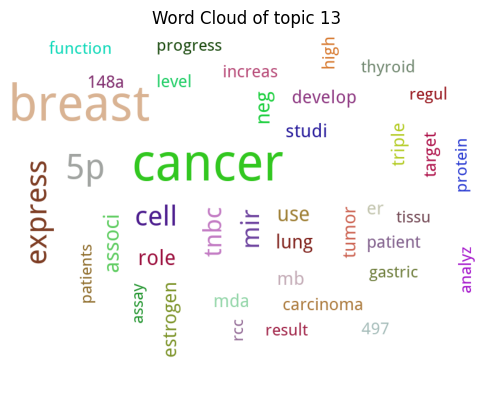

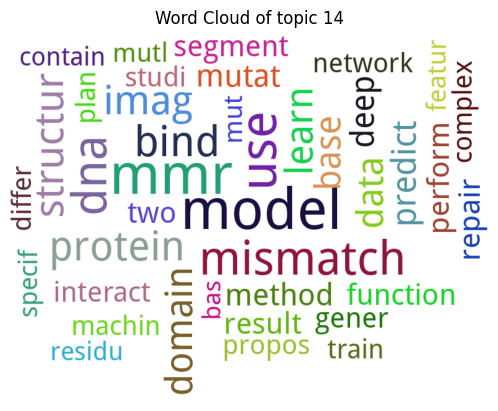

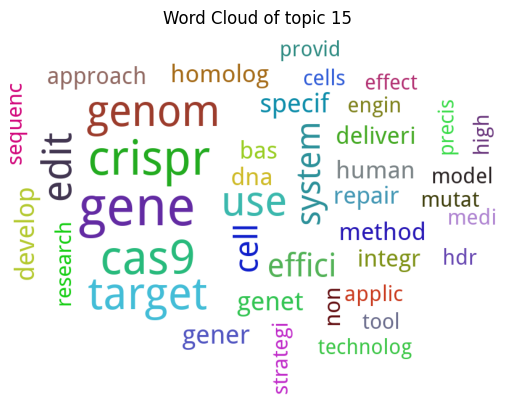

In [29]:
n_top_words = 40

top_words = []
for topic in lda.components_:
    # Get the indices of the top words in the topic
    top_word_indices = topic.argsort()[-n_top_words:]
    
    # Get the top words and their corresponding TF-IDF values
    top_words.append([(cv.get_feature_names_out()[i], topic[i]) for i in top_word_indices])

# Generate a word cloud for each topic
for i, words in enumerate(top_words):
    tags = make_tags(words, maxsize=80, minsize=20)
    create_tag_image(tags, f'topic_{i+1}.png', size=(900, 600))
    image = plt.imread(f'topic_{i+1}.png')
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Word Cloud of topic {i+1}")
    plt.show()

Using the attributes of the LDA model of sklearn.decomposition library, I put the word and<br>
their relative weights(frequency) into a dataframe to see the results better. <br>
Topic column of the dataframe shows the topics, for each topic to keep it simple I put the words with<br>
top 5 frequencies.

In [30]:
import pandas as pd

topic_term_matrix = lda.components_

# Create a list of the words in the vocabulary
vocab = cv.get_feature_names_out()

#insight to the vocabulary
print(vocab[-10:])

# Create a DataFrame with 3 columns:"topic", "word" and "weight"
df_word_weight = pd.DataFrame(columns=['topic', 'word', "weight"])

# Iterate over each topic in the topic-term matrix
for topic_idx, topic in enumerate(topic_term_matrix):
    
    # Sort the words in the topic by their weight
    topic_words = [(vocab[i], topic[i]) for i in topic.argsort()[::-1]]

    # Append the word-weight pairs to the DataFrame
    for word, weight in topic_words[:5]:
        total_topic_weight = len(topic_words)
        temp_df = pd.DataFrame([[topic_idx+1, word, f"{(weight/total_topic_weight):.3f}"]], columns = ["topic", "word", "weight"])
        df_word_weight = pd.concat([df_word_weight, temp_df], ignore_index=True)
        
display(df_word_weight.head(10))

['zygoten' 'zygotene' 'zygotes' 'zymocin' 'zymogen' 'zymographi'
 'zymography' 'zymoseptoria' 'zyxin' 'ϵa']


,topic,word,weight
0,1,repeat,0.012
1,1,cell,0.008
2,1,expans,0.006
3,1,mmr,0.006
4,1,repair,0.005
5,2,risk,0.036
6,2,cancer,0.033
7,2,polymorph,0.032
8,2,associ,0.029
9,2,95,0.026


### LDA Model from gensim.models Evaluation

Using LDA model from gensim.models I made topic clusters, that stores the articles based on what is their most<br>
dominant topics are. Based on this I will create trend analysis with articles and topics.

In [31]:
# Create a list of <optimal_number_of_topics> empty lists, one for each topic cluster
topic_clusters = [[] for _ in range(optimal_number_of_topics)]

# Iterate over the documents and append each document to the appropriate topic cluster
for i, doc in enumerate(documents):
    dominant_topic = max(lda_model.get_document_topics(bow_corpus[i]), key=lambda x: x[1])
    topic_clusters[dominant_topic[0]].append(doc)

For each article that published after 2000 (Since there aren't many articles before that I discarded the rest),<br>
using the ***topic_clusters above***, I've grouped the articles that are similar and published in the same year into<br>
***count_similar_articles_per_year*** list and then grouped them just by year to get total count of published articles<br>
for each year and stored it in ***count_total_articles_per_year*** list.<br>

Using these two lists I found the **normalized frequency of publications** for each year.

In [32]:
# Get years after 2000
df_t = df[df.Date >= str(2000)]

min_year = int(df_t.Date.min())
max_year = int(df_t.Date.max())

# For each distinct year, make a list of the years
years = df_t.Date.unique()

years.sort()

# Count of similar articles per year for each topic cluster
count_similar_articles_per_year = []
for topic_cluster in topic_clusters:
    count_similar_articles_per_year.append(
        {year: 
         len([doc for doc in topic_cluster if doc[-4:] == year])
         for year in years})
    

# Total number of articles published in each year
count_total_articles_per_year = {year: 
                                 len([doc for doc in documents if doc[-4:] == year])
                                 for year in years}

# Calculate the normalized frequency of publication for each topic cluster
normalized_frequency_publication = []

for count_similar_articles in count_similar_articles_per_year:
    normalized_frequency_publication.append(
        {year:
         count_similar_articles[year] / count_total_articles_per_year[year] 
         for year in years})

# Print the first 3 topic clusters
for i, topic_cluster in enumerate(topic_clusters):
    if i == 3:
        break
    print(f"Topic cluster {i+1}:")
    print(f"{normalized_frequency_publication[i]}")

Topic cluster 1:
{'2000': 0.14814814814814814, '2001': 0.1476510067114094, '2002': 0.12408759124087591, '2003': 0.16574585635359115, '2004': 0.09836065573770492, '2005': 0.17452830188679244, '2006': 0.15942028985507245, '2007': 0.1625, '2008': 0.1822429906542056, '2009': 0.13108614232209737, '2010': 0.14285714285714285, '2011': 0.14516129032258066, '2012': 0.14435695538057744, '2013': 0.13501144164759726, '2014': 0.1461187214611872, '2015': 0.15327102803738318, '2016': 0.14338919925512103, '2017': 0.15408320493066255, '2018': 0.135258358662614, '2019': 0.16643356643356644, '2020': 0.1540948275862069, '2021': 0.16666666666666666, '2022': 0.14452709883103082, '2023': 0.11764705882352941}
Topic cluster 2:
{'2000': 0.08333333333333333, '2001': 0.0738255033557047, '2002': 0.10948905109489052, '2003': 0.08287292817679558, '2004': 0.07103825136612021, '2005': 0.10849056603773585, '2006': 0.1111111111111111, '2007': 0.05416666666666667, '2008': 0.06074766355140187, '2009': 0.07116104868913857,

For trend analysis I used Mann-Kendall test, used ***original_test*** function from **pymannkendall**, which returns:<br>
<code>    </code>**trend**: tells the trend (increasing, decreasing or no trend)<br>
<code>    </code>**h**: True (if trend is present) or False (if the trend is absence)<br>
<code>    </code>**p**: p-value of the significance test<br>
<code>    </code>**z**: normalized test statistics<br>
<code>    </code>**Tau**: Kendall Tau<br>
<code>    </code>**s**: Mann-Kendal's score<br>
<code>    </code>**var_s**: Variance S<br>
<code>    </code>**slope**: Theil-Sen estimator/slope<br>
<code>    </code>**intercept**: intercept of Kendall-Theil Robust Line, for seasonal test, full period cycle consider as unit time step

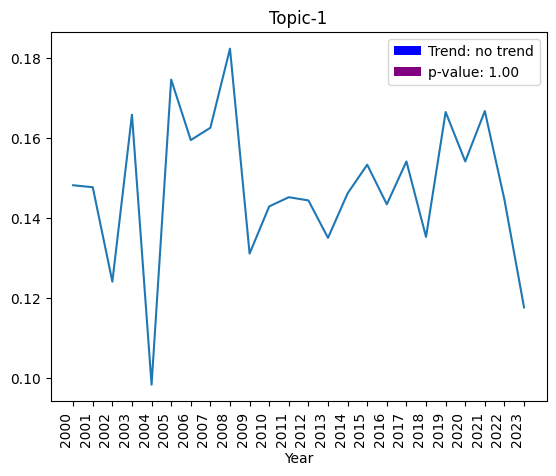

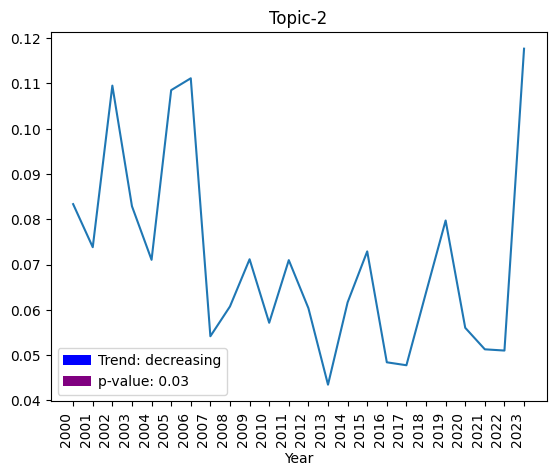

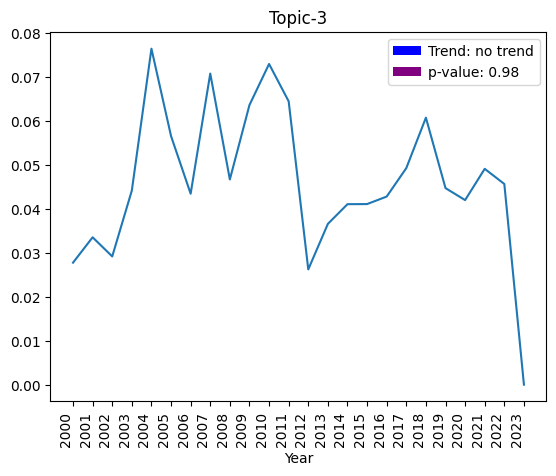

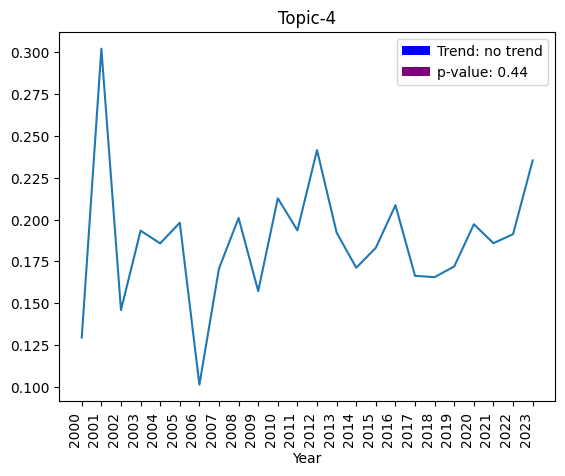

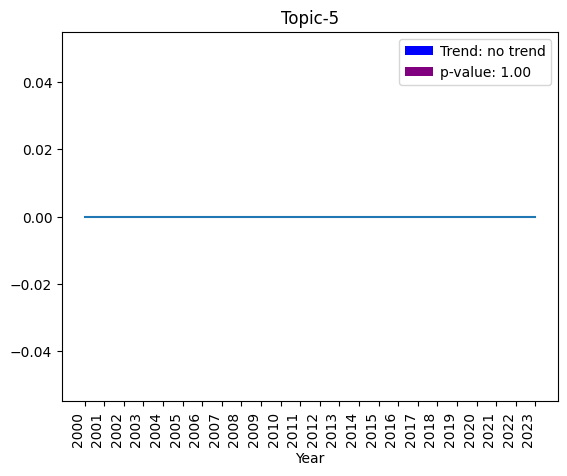

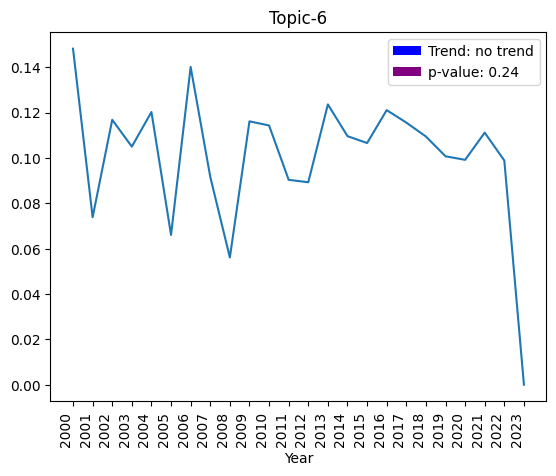

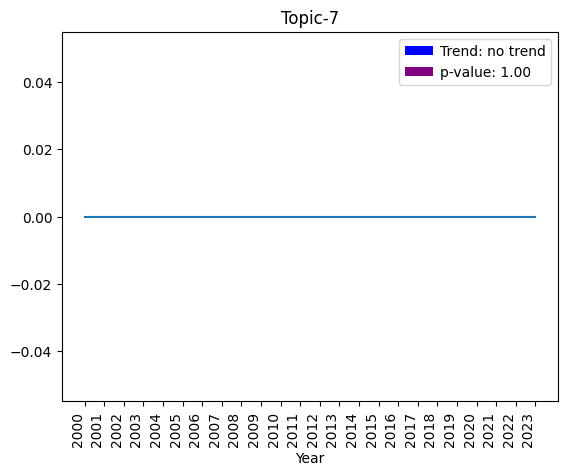

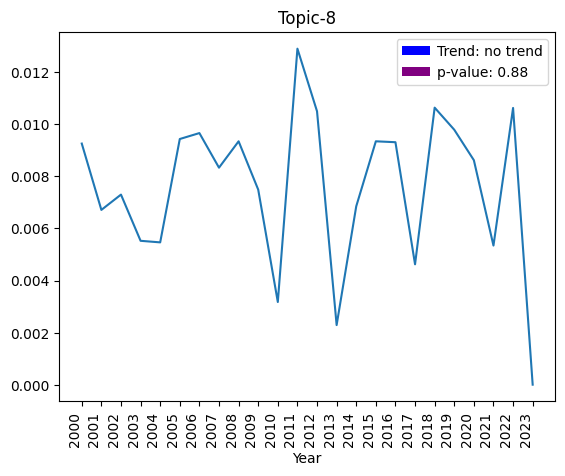

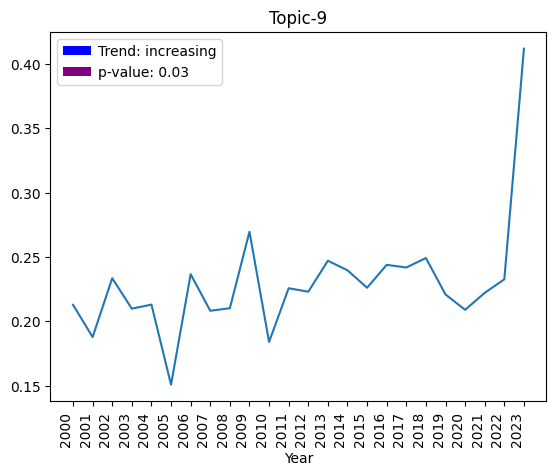

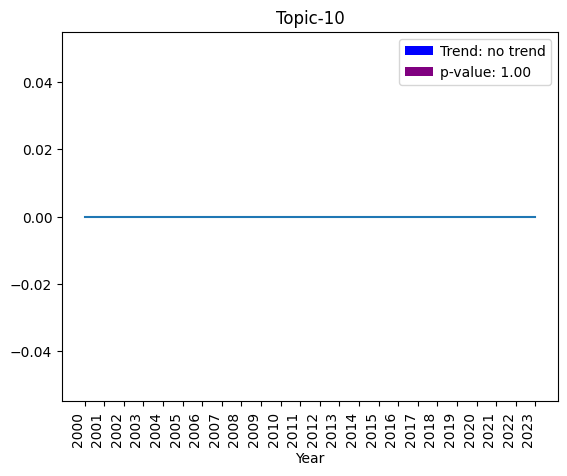

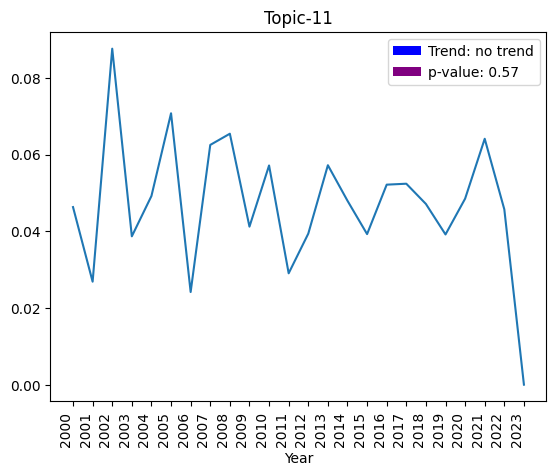

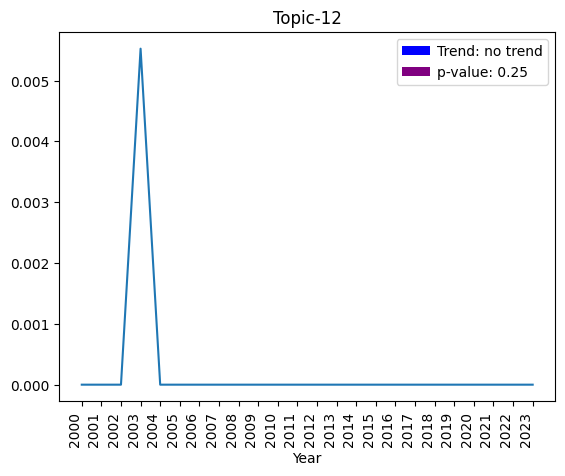

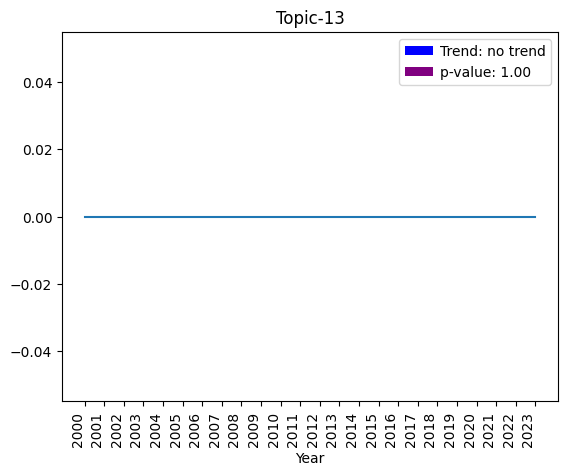

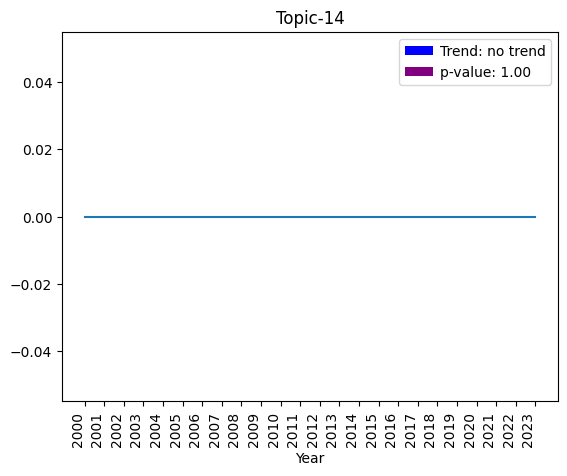

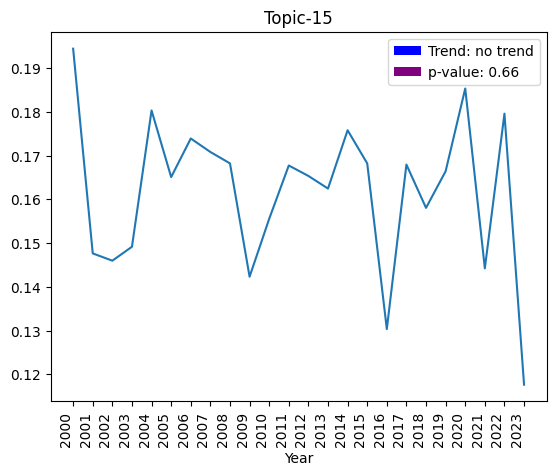

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pymannkendall as mk

for i, topic_cluster in enumerate(normalized_frequency_publication):
    
    fig, ax = plt.subplots()
    
    x = list(topic_cluster.keys())
    y = list(topic_cluster.values())
    
    # Calculate the Mann-Kendall test statistic and p-value for each topic cluster
    mk_result = mk.original_test(list(topic_cluster.values()))
    
    # Plot the normalized frequency of publication over time
    ax.plot(x, y, label=f"Topic-{i+1}")

    ax.set_title(f"Topic-{i+1}")
    ax.set_xlabel("Year")
    
    # Add the trend and p-value from the Mann-Kendall test to the plot as a legend
    ax.legend(handles=[
        Patch(facecolor="blue", label=f"Trend: {mk_result.trend}"),
        Patch(facecolor="purple", label=f"p-value: {mk_result.p:.2f}")
    ], handletextpad=0.5, columnspacing=1)
    plt.xticks(rotation=90, ha="right")

    plt.show()

### Named Entity Recognition (NER) Evaluation

Got the ***get_entity_options*** function from https://github.com/allenai/scispacy/issues/141.<br>
<font color='grey'>(Author states that he gives permission for personal use.)</font><br>
It is simply a color generator for the entity visualizations.

In [34]:
import random 

def get_entity_options(random_colors=False):
    """
    generating color options for visualizing the named entities
    """
    def color_generator(number_of_colors):
        color = ["#"+''.join([random.choice('123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
        return color

    entities = ["GGP", "SO", "TAXON", "CHEBI", "GO", "CL", 
                "DNA", "CELL_TYPE", "CELL_LINE", "RNA", "PROTEIN",
                "DISEASE", "CHEMICAL",
                "CANCER", "ORGAN", "TISSUE", "ORGANISM", "CELL", "AMINO_ACID", "GENE_OR_GENE_PRODUCT", "SIMPLE_CHEMICAL", "ANATOMICAL_SYSTEM", "IMMATERIAL_ANATOMICAL_ENTITY", "MULTI-TISSUE_STRUCTURE", "DEVELOPING_ANATOMICAL_STRUCTURE", "ORGANISM_SUBDIVISION", "CELLULAR_COMPONENT"]
    
    colors = {"ENT":"#E8DAEF"}
    
    if random_colors:
        color = color_generator(len(entities))
        for i in range(len(entities)):
            colors[entities[i]] = color[i]
    else:
        entities_cat_1 = {"GGP":"#F9E79F", "SO":"#F7DC6F", "TAXON":"#F4D03F", "CHEBI":"#FAD7A0", "GO":"#F8C471", "CL":"#F5B041"}
        entities_cat_2 = {"DNA":"#82E0AA", "CELL_TYPE":"#AED6F1", "CELL_LINE":"#E8DAEF", "RNA":"#82E0AA", "PROTEIN":"#82E0AA"}
        entities_cat_3 = {"DISEASE":"#D7BDE2", "CHEMICAL":"#D2B4DE"}
        entities_cat_4 = {"CANCER":"#ABEBC6", "ORGAN":"#82E0AA", "TISSUE":"#A9DFBF", "ORGANISM":"#A2D9CE", "CELL":"#76D7C4", "AMINO_ACID":"#85C1E9", "GENE_OR_GENE_PRODUCT":"#AED6F1", "SIMPLE_CHEMICAL":"#76D7C4", "ANATOMICAL_SYSTEM":"#82E0AA", "IMMATERIAL_ANATOMICAL_ENTITY":"#A2D9CE", "MULTI-TISSUE_STRUCTURE":"#85C1E9", "DEVELOPING_ANATOMICAL_STRUCTURE":"#A9DFBF", "ORGANISM_SUBDIVISION":"#58D68D", "CELLULAR_COMPONENT":"#7FB3D5"}

        entities_cats = [entities_cat_1, entities_cat_2, entities_cat_3, entities_cat_4]
        for item in entities_cats:
            colors = {**colors, **item}
    
    options = {"ents": entities, "colors": colors,
        "font": "Helvetica",
        "ent_color": "#006699"
        }
    
    return options

Displacy is a visualizer tool that is provided by spacy library.<br>
Here I've rendered the docs that I've gathered from NER models to display it.<br>
If the jupyter parameter set to False it will return html file and if it's true it will display it here.<br>
<font color=grey>With the ability to get the return value as html, we can easily implement it into any website.</font>

In [37]:
from spacy import displacy

options = get_entity_options(random_colors=True)

displacy.render(doc_bionlp13cg[:100], jupyter=True, style="ent", options=options)
# html = displacy.render(doc_bionlp13cg, jupyter=False, style="ent", options=options)
# with open("<file_name>.html", "w", encoding="utf-8") as f:
#     f.write(html)
    
displacy.render(doc_bc5cdr[:100], style="ent", jupyter=True,options=options)
# html = displacy.render(doc_bc5cdr, style="ent", jupyter=False,options=options)
# with open("<file_name>.html", "w", encoding="utf-8") as f:
#     f.write(html)

displacy.render(doc_core[:100], jupyter=True, style="ent")
# html = displacy.render(doc, jupyter=False, style="ent")
# with open("<file_name>.html", "w", encoding="utf-8") as f:
#     f.write(html)

# Print first 10 variables to get an insight
print(doc_bionlp13cg.ents[:10])
print(doc_bc5cdr.ents[:10])
print(doc_core.ents[:10])

(cancer cell, histone deacetylases, HDACs, DNA, histone, cancer, human, anti-cancer, breast cancer, TNBC)
(cancer, cancer, breast cancer, TNBC, TNBC, breast cancer, triple-negative breast cancer, zinc, neurodegenerative diseases, Huntington's disease)
(microRNA, microRNA, HDAC, microRNA, HDAC, HDAC, transcription, Technique, Electroporation (TAKE, DDR)


I've put together most mentioned ***gene_or_gene_products*** and ***disease*** into seperate lists.<br>
Then I will plot these to see frequencies of these.<br>
These will be simple displays, we can do this for any of the entities or even combine them.

In [38]:
from collections import Counter

# Get gene_or_gene_products
genes = [ent.text for ent in doc_bionlp13cg.ents if ent.label_ == "GENE_OR_GENE_PRODUCT"]

diseases = [ent.text for ent in doc_bc5cdr.ents if ent.label_ == "DISEASE"]

# Combine gene entities such as PARP1, PARP2 and PARP into PARP
for i in range(len(genes)):
    if "PARP" in genes[i]:
        genes[i] = "PARP"

diseases = [disease for disease in diseases if not(len(disease.split(" ")) == 1 and "cancer" in disease)]
for i in range(len(diseases)):
    if len(diseases[i].split(" ")) == 1 and "tumor" in diseases[i]:
        diseases[i] = "tumor"

common_genes = Counter(genes).most_common(10)
common_diseases = Counter(diseases).most_common(10)

 ##### Plot for Gene and Gene Producs

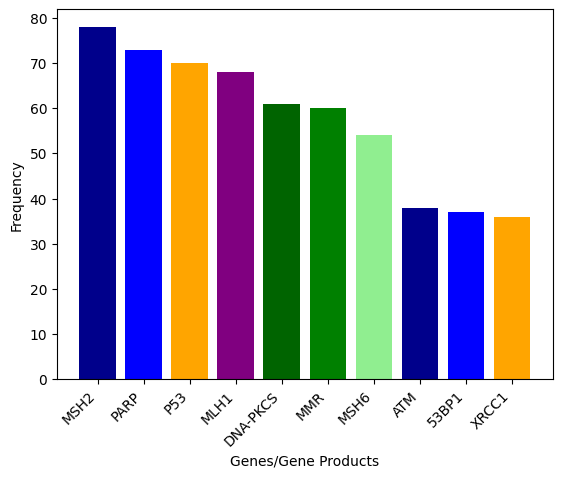

In [39]:
X = []
Y = []
for x,y in common_genes:
    X.append(x.upper())
    Y.append(y)

colors = ['darkblue', 'blue', 'orange', 'purple', 'darkgreen', 'g', 'lightgreen']
plt.bar(X,Y,color = colors)
plt.xlabel("Genes/Gene Products")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()

##### Plot for Diseases

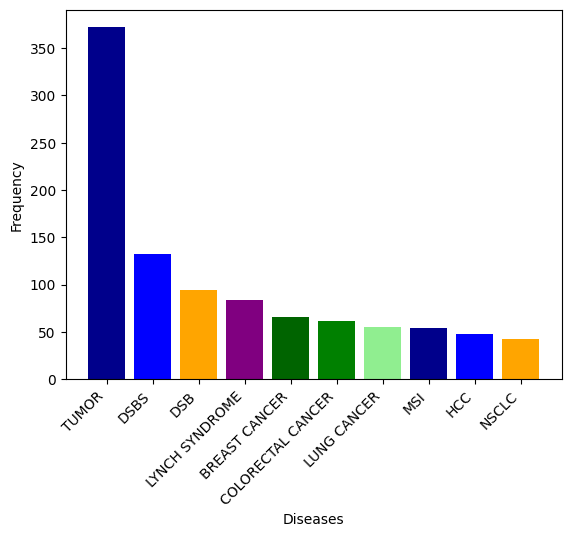

In [40]:
X = []
Y = []
for x,y in common_diseases:
    X.append(x.upper())
    Y.append(y)

colors = ['darkblue', 'blue', 'orange', 'purple', 'darkgreen', 'g', 'lightgreen']
plt.bar(X,Y,color = colors)
plt.xlabel("Diseases")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()

#### RETURN SIMILAR DOCUMENTS

At last, to show functionality of the LDA models, I implemented a search function which takes 4 arguments:<br>
<code>    </code>**query**: Search query, throws an error if it's empty. Results will depend on the documents.<br>
<code>    </code>**documents**: Documents to search from, provided by implementor, limited to returned articles by Entrez. <br>
<code>    </code>**lda_model**: Expects the LDA model of gensim.models, provided by the implementor, will be used to search similarities.<br>
<code>    </code>**dictionary**: Expects the Dictionary class of gensim.corpora, also will be used to search for similarities.<br>
<br>
**Note**:<br>
Since we are limited to gathered articles from PubMed, and the articles are in the field of biomedical science<br>
search queries that are not specific to these fields, would return unsatisfying documents. 

In [41]:
# Used for preproccessing the given search query
def preprocess(review):
    review = review.lower()
    review = review.split()
    #gets the root of the word -----> likely >> like
    ps = PorterStemmer() 
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = [word for word in review if len(word) > 2]
    review = ' '.join(review)
    return review

In [104]:
import numpy as np
from gensim.matutils import corpus2dense
from sklearn.metrics.pairwise import cosine_similarity

def search(query, documents, lda_model, dictionary):
    if query ==  "":
        print("ERROR, Search Query should not be empty!")
        return
     
    # Preprocess the search query
    query = preprocess(query)

    # Calculate the topic distribution for the search query
    query_topics = corpus2dense([
        lda_model.get_document_topics(dictionary.doc2bow(query.split()))], 
        num_terms=len(dictionary)).T[0]

    # Calculate the similarity between the search query and each document
    similarities = []
    for doc in documents:
        doc_topics = corpus2dense([
            lda_model.get_document_topics(dictionary.doc2bow(doc.split()))],
            num_terms=len(dictionary)).T[0]
        similarity = cosine_similarity([query_topics], [doc_topics])[0][0]
        similarities.append(similarity)

    # Sort the documents by their similarity to the search query
    sorted_indices = np.argsort(similarities)[::-1]
    
   
    for i in sorted_indices:
        # get the id
        id = documents[i][::-1].split(".",1)[0].split()[1]
        # sşmilarity score
        similarity_score = round(similarities[i],2)
        # title of the article
        title = documents[i].split(".")[0]
        # link to the article
        link = "https://pubmed.ncbi.nlm.nih.gov/"+id+"/"
        yield f"""Title: {title}    
        Similarity = {round(similarity_score*100,2)}
        Link of the article: {link}
        """     



Using the ***yield*** properties, we can get only 1 article each time we get ***next***.<br>
If there is no more to yield, I will just display "No more articles!".<br>
Since similarities will drop each time, user will get less relevant article for each next.

In [152]:
search_results = search("Properties of DNA", documents, lda_model, dictionary)
print(next(search_results))

Title: In vitro repair of complex unligatable oxidatively induced DNA double-strand breaks by human cell extracts    
        Similarity = 99.0
        Link of the article: https://pubmed.ncbi.nlm.nih.gov/40364553/
        


In [176]:
try:
    print(next(search_results))
    print(next(search_results))
    print(next(search_results))
    print(next(search_results))
    print(next(search_results))
except StopIteration:
    print("No more articles!")

Title: Long non coding RNA OIP5‑AS1 promotes metastasis of breast cancer via miR‑340‑5p/ZEB2 axis    
        Similarity = 95.0
        Link of the article: https://pubmed.ncbi.nlm.nih.gov/44588482/
        
Title: Promiscuous mismatch extension by human DNA polymerase lambda    
        Similarity = 95.0
        Link of the article: https://pubmed.ncbi.nlm.nih.gov/61370861/
        
Title: MiroRNA-127-3p targets XRCC3 to enhance the chemosensitivity of esophageal cancer cells to a novel phenanthroline-dione derivative    
        Similarity = 95.0
        Link of the article: https://pubmed.ncbi.nlm.nih.gov/41488213/
        
Title: MicroRNA‑93‑5p promotes the progression of human retinoblastoma by regulating the PTEN/PI3K/AKT signaling pathway    
        Similarity = 95.0
        Link of the article: https://pubmed.ncbi.nlm.nih.gov/12222361/
        
Title: UV-induced endonuclease III-sensitive sites at the mating type loci in Saccharomyces cerevisiae are repaired by nucleotide exci

Save LDA and NER models.

In [182]:
# Save the model and dictionary to files
lda_model.save("lda_model.model")
dictionary.save_as_text("dictionary.txt")

In [183]:
import pickle

# Save the models to a file
with open("models.pkl", "wb") as f:
    pickle.dump((nlp_bionlp13cg, nlp_bc5cdr, nlp), f)

Load back from memory.

In [184]:
# Load the model and dictionary from files
lda_model = LdaModel.load("lda_model.model")
dictionary = Dictionary.load_from_text("dictionary.txt")

In [ ]:
# Load the models from a file
with open("models.pkl", "rb") as f:
    nlp_bionlp13cg, nlp_bc5cdr, nlp = pickle.load(f)

## References<a class="anchor" id="references"></a>

https://pubmed.ncbi.nlm.nih.gov/<br>
https://www.kaggle.com/code/binitagiri/extract-data-from-pubmed-using-python<br>
https://www.ncbi.nlm.nih.gov/<br>
https://www.nlm.nih.gov/<br>
https://github.com/biopython/biopython/issues/1867<br>
https://biopython-tutorial.readthedocs.io/en/latest/notebooks/09%20-%20Accessing%20NCBIs%20Entrez%20databases.html#EFetch:-Downloading-full-records-from-Entrez<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html<br>
https://matplotlib.org/stable/api/cm_api.html<br>
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.barh.html<br>
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0<br>
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html<br>
https://youtu.be/TKjjlp5_r7o<br>
https://radimrehurek.com/gensim/models/coherencemodel.html<br>
https://allenai.github.io/scispacy/<br>
https://spacy.io/usage/visualizers<br>
https://stackoverflow.com/questions/18974437/how-to-build-a-clean-word-cloud-using-pytagcloud-without-a-crowded-image-pytho<br>
https://pypi.org/project/pymannkendall/<br>
https://github.com/allenai/scispacy/issues/141<br>
https://leonlok.co.uk/blog/finding-similar-names-using-cosine-similarity/<br>


**Disclaimer!** <font color='grey'>This notebook was prepared by Orhan Aytekin as a term project for the *BBM467 - Data Intensive Applications* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>